In [2]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# File paths
input_file = "../data/Almond disease survey data ALL.csv"
output_file = "../data/HR_processed_data.csv"

In [4]:
# aggregate year, orchard and variety to calculate HR incidence

def preprocess_almond_data(file_path, output_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Trim column names to remove extra spaces
    df.columns = df.columns.str.strip()
    
    df = df[(df["Variety"] != "Unknown")]

    # Standardize categorical values (ensure consistent case formatting)
    df["Orchard"] = df["Orchard"].str.strip().str.title()
    df["Variety"] = df["Variety"].str.strip().str.title()
    df["Hull split"] = df["Hull split"].str.strip()

    # Ensure Year is treated as a categorical variable for filtering later
    df["Year"] = df["Year"].astype(str).str.strip()

    columns_to_drop = [
    'Row', 'Tree', 'Tree#', 'Row spacing', 'Tree spacing', "Region Wt",	"Block",	
    "Area ha",	"TotalOrchard Area", 'Orchard wt', 'Orchard_Scale',	'RegionTotal Ha',
    'HullRot_WTD',	'HullRotJOhull', 'LLDB dead branches', 'LLDBYellowing', 'LLDB combo', 
    'Gumtrunk', 'Gumscaffold', 'Gumtree crotch', 'Trunkcankers', 'Twig canker', 'Foamy canker', 
    'TD combo', 'Wilting - whole tree decline', 'Wilting - one scaffold', 'Wiltcombo',
    'Anthracnose - nut', 'Anthracnose - leaf', 'Anthracnose combo',
    'Bacterial spot - nut', 'Bacterial spot - leaf', 'Bacterial spot combo',
    'Scab - nut', 'Scab - leaf', 'Scab combo', 'Rust', 'Shot Hole - nut',
    'Shot Hole - leaf', 'Shotholecombo', 'Alternaria leaf spot',
    'Unknown leaf spot/ symptom', 'Unknown fruit spot/ symptom', 'Unknown fruit gum'
    ]

    df = df.drop(columns=columns_to_drop)

    # Define relevant columns for weather data aggregation
    weather_columns = [
        "Days over 40C", "Days over 35C", "Total Amount of rain ml since 1 Jan",
        "No of rain days since 1 Jan", 'Days since last rain <5days from assess', 
        'Amt rain in last event<5days from assess', 'Days since last rain >5days from assess', 
        'Amt rain in last event>5days from assess', 'Total rain Jan mm', 'No rain days Jan', 
        'Total rain Feb mm', 'No rain days Feb', 'Rain 1st week Jan', 'Rain 2nd week  Jan', 'Rain 3rd week  Jan', 
        'Rain 4th week  Jan', 'Rain within 7 days of assessment', 'Rain within 10 days of assessment'
    ]

    hull_rot_columns = ["HR comboF"]

    # Remove rows with Hull split = "Not Split" before aggregation
    df = df[df["Hull split"] != "Not Split"]

    # Aggregate weather again after filtering
    weather_data = df.groupby(["Year", "Orchard", "Variety"])[weather_columns].first().reset_index()

    # Recompute tree counts and HR incidence after filtering
    tree_counts = df.groupby(["Orchard", "Variety", "Year"]).size().reset_index(name="Total_Trees_Assessed")
    hull_rot_proportion = df.groupby(["Orchard", "Variety", "Year"])[hull_rot_columns].sum().reset_index()

    # Calculate HR Incidence
    hull_rot_proportion["HR Incidence"] = hull_rot_proportion["HR comboF"] / tree_counts["Total_Trees_Assessed"]


    # Final merged summary dataset (one row per Year, Orchard, Variety)
    final_df = (
        weather_data
        .merge(tree_counts, on=["Orchard", "Variety", "Year"], how="left")
        .merge(hull_rot_proportion[["Orchard", "Variety", "Year", "HR Incidence"]], on=["Orchard", "Variety", "Year"], how="left")
    )

    # Save processed data
    final_df.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")
    print(final_df)

preprocess_almond_data(input_file, output_file)

Processed data saved to ../data/HR_processed_data.csv
        Year    Orchard       Variety  Days over 40C  Days over 35C  \
0    2018.19  Belvedere        Carmel           16.0           28.0   
1    2018.19  Belvedere      Monterey           16.0           28.0   
2    2018.19  Belvedere            Np           16.0           28.0   
3    2018.19  Belvedere         Price           16.0           28.0   
4    2018.19    Bennett        Carmel            8.0           14.0   
..       ...        ...           ...            ...            ...   
192   2019.2      Wemen         Price            2.0            8.0   
193   2019.2     Yilgah        Carmel            6.0           16.0   
194   2019.2     Yilgah  Independence            6.0           16.0   
195   2019.2     Yilgah            Np            6.0           16.0   
196   2019.2     Yilgah         Price            6.0           16.0   

     Total Amount of rain ml since 1 Jan  No of rain days since 1 Jan  \
0                   

In [5]:
# Load your processed dataset
df = pd.read_csv("../data/HR_processed_data.csv")

# Step 1: Check missing value count and percentage
missing_summary = df.isnull().sum().to_frame(name="MissingCount")
missing_summary["MissingPercent"] = (missing_summary["MissingCount"] / len(df)) * 100
print("🔍 Missing Value Summary:")
print(missing_summary)

# Step 2: Drop columns with more than 30% missing data
threshold = 30  # percent
cols_to_drop = missing_summary[missing_summary["MissingPercent"] > threshold].index.tolist()
df_cleaned = df.drop(columns=cols_to_drop)

print(f"\n✅ Dropped columns with >{threshold}% missing data: {cols_to_drop}")

# Step 3: Impute remaining missing numerical values with median
numeric_cols = df_cleaned.select_dtypes(include=["float64", "int64"]).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].median())

# Optional: Save cleaned dataset
df_cleaned.to_csv("../data/HR_processed_cleaned.csv", index=False)
print("\n✅ Cleaned dataset saved to 'HR_processed_cleaned.csv'")


🔍 Missing Value Summary:
                                          MissingCount  MissingPercent
Year                                                 0        0.000000
Orchard                                              0        0.000000
Variety                                              0        0.000000
Days over 40C                                        3        1.522843
Days over 35C                                        3        1.522843
Total Amount of rain ml since 1 Jan                  3        1.522843
No of rain days since 1 Jan                          3        1.522843
Days since last rain <5days from assess             59       29.949239
Amt rain in last event<5days from assess             3        1.522843
Days since last rain >5days from assess              3        1.522843
Amt rain in last event>5days from assess             3        1.522843
Total rain Jan mm                                    3        1.522843
No rain days Jan                                    


🔍 Top Correlated Features with HR Incidence:
No rain days Feb                            0.412874
Amt rain in last event>5days from assess    0.391625
Total Amount of rain ml since 1 Jan         0.356308
Rain within 10 days of assessment           0.347415
Total rain Feb mm                           0.346684
No of rain days since 1 Jan                 0.327235
Rain 3rd week  Jan                          0.318742
Total rain Jan mm                           0.297015
Amt rain in last event<5days from assess    0.293854
Rain within 7 days of assessment            0.288833
No rain days Jan                            0.169819
Total_Trees_Assessed                        0.160686
Year                                        0.122765
Days over 35C                               0.089144
Rain 2nd week  Jan                          0.073808
Days over 40C                               0.042301
Days since last rain <5days from assess    -0.016474
Rain 4th week  Jan                         -0.033030


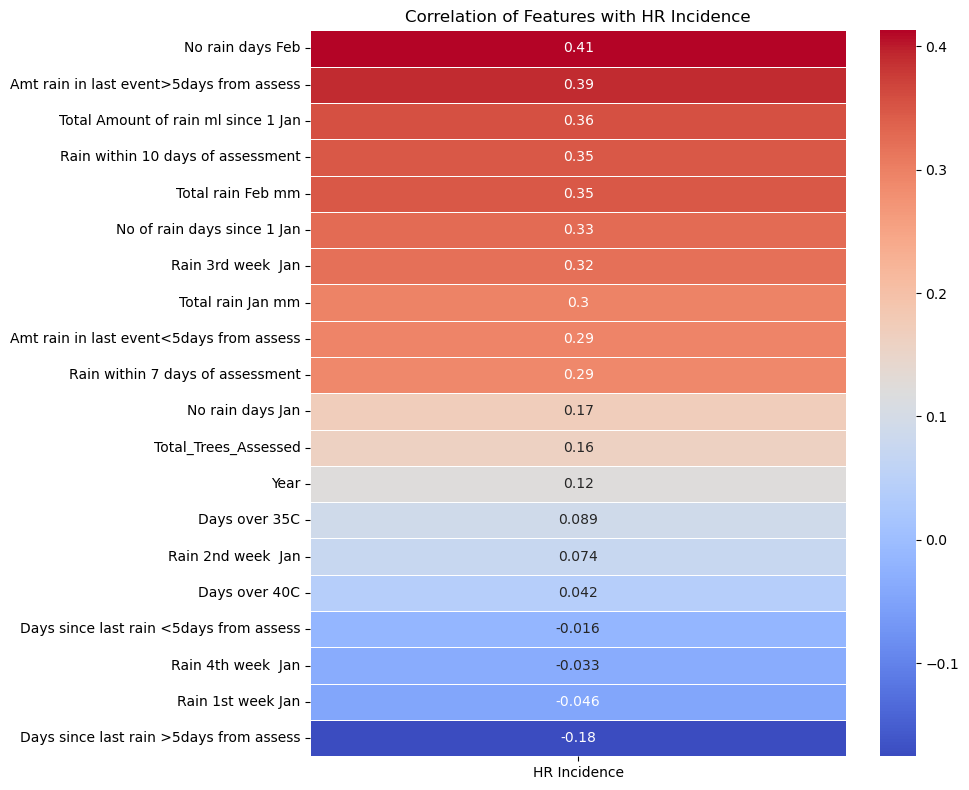

In [6]:
# Step 3: Correlation matrix
corr_matrix = df_cleaned.corr(numeric_only=True)

# Focus only on correlation with HR Incidence
hr_corr = corr_matrix["HR Incidence"].drop("HR Incidence").sort_values(ascending=False)

# Print correlation values
print("\n🔍 Top Correlated Features with HR Incidence:")
print(hr_corr)

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hr_corr.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Correlation of Features with HR Incidence")
plt.tight_layout()
plt.show()